# **Step 1: Import Libraries**

In [1]:
pip install fastai 

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import Standard Libraries
import os
import zipfile
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from glob import glob

# Import Machine Learning Libraries
import torch
import torchvision.transforms as transforms
from torchvision.models import swin_v2_t, Swin_V2_T_Weights
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Import Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import TensorFlow
import tensorflow as tf

2024-11-23 18:28:21.338178: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732382901.361296 1836658 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732382901.368228 1836658 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-23 18:28:21.394316: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


**Set Seed for Reproducibility**

In [3]:
SEED = 42

def seed_everything(seed=SEED):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set Seed for Reproducibility
seed_everything()

# **Step 2: Load Data**

In [4]:
# Define Paths
ZIP_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14.zip'
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14-extracted'

# Function to Extract ZIP File
def extract_data(zip_path, extracted_path):
    os.makedirs(extracted_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)

# Extract Data # TODO
# extract_data(ZIP_PATH, EXTRACTED_PATH)

# **Step 3: Data Preprocessing**

In [5]:
# Define Disease Labels
disease_labels = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
    'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
    'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
]

# Load Labels CSV
labels_csv_path = os.path.join(EXTRACTED_PATH, 'Data_Entry_2017.csv')
labels_df = pd.read_csv(labels_csv_path)

# Initialize One-Hot Encoding Columns
for disease in disease_labels:
    labels_df[disease] = 0

# Vectorized One-Hot Encoding
for disease in disease_labels:
    labels_df[disease] = labels_df['Finding Labels'].str.contains(disease).astype(int)

# Handle 'No Finding'
labels_df['No_Finding'] = labels_df['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

# Split Multiple Labels into Lists
labels_df['Finding Labels'] = labels_df['Finding Labels'].apply(lambda s: [label.strip() for label in s.split('|')])

# Map Image Index to Paths
num_glob = glob(os.path.join(EXTRACTED_PATH, '**', 'images', '*.png'), recursive=True)
img_path_dict = {os.path.basename(x): x for x in num_glob}

# Assign Paths to Labels DataFrame
labels_df['Path'] = labels_df['Image Index'].map(img_path_dict)

# **Step 4: Exploratory Data Analysis (EDA)**

**Number of Unique Patients**

In [6]:
unique_patients = labels_df['Patient ID'].nunique()
print(f"Number of Unique Patients: {unique_patients}")

Number of Unique Patients: 30805


**Label Distribution**

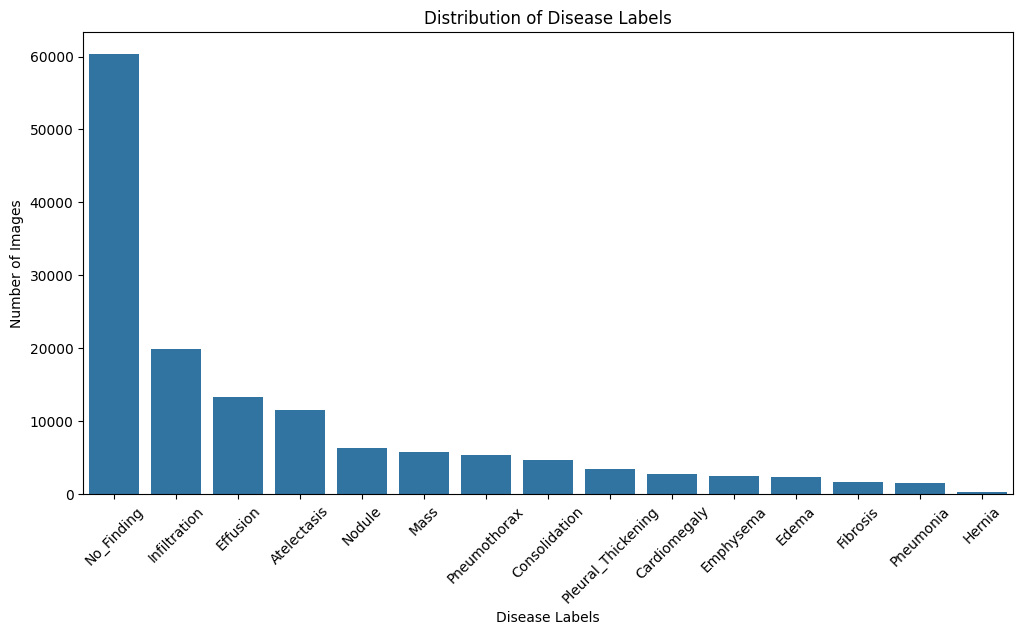

In [7]:
label_counts = labels_df[disease_labels + ['No_Finding']].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xticks(rotation=45)
plt.title("Distribution of Disease Labels")
plt.ylabel("Number of Images")
plt.xlabel("Disease Labels")
plt.show()

**Patient Gender Distribution**

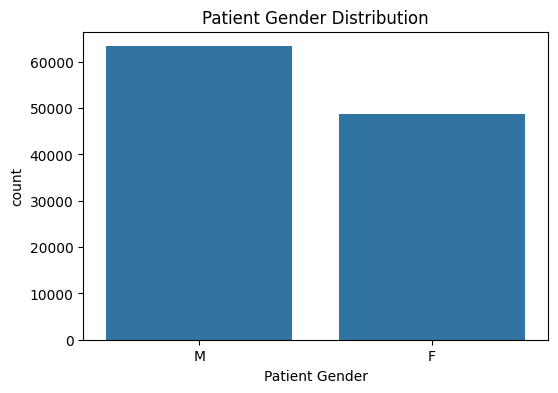

In [8]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Patient Gender', data=labels_df)
plt.title("Patient Gender Distribution")
plt.show()

**Patient Age Distribution**

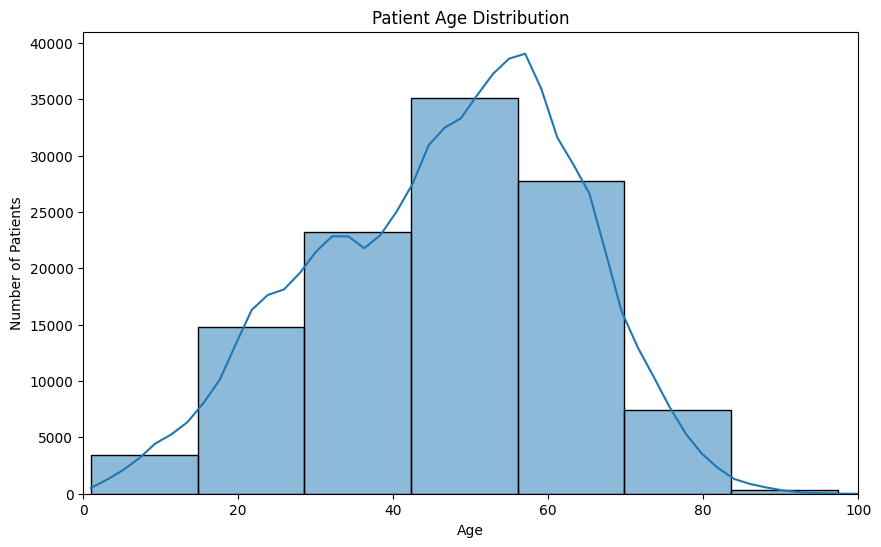

In [9]:
# Patient Age Distribution
plt.figure(figsize=(10, 6))
sns.histplot(labels_df['Patient Age'], bins=30, kde=True)
plt.title("Patient Age Distribution")
plt.xlabel("Age")
plt.ylabel("Number of Patients")
plt.xlim(0, 100)
plt.show()

**View Position Distribution**

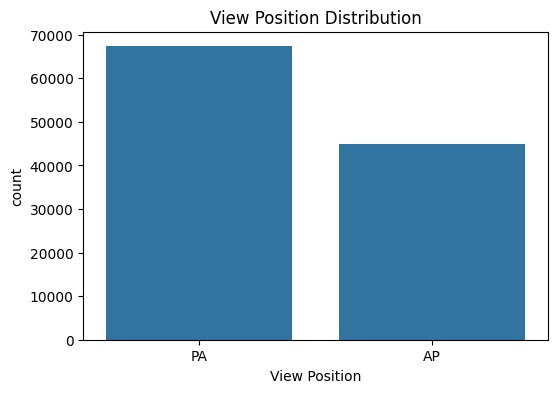

In [10]:
plt.figure(figsize=(6, 4))
sns.countplot(x='View Position', data=labels_df)
plt.title("View Position Distribution")
plt.show()

**Correlation Matrix for Labels**

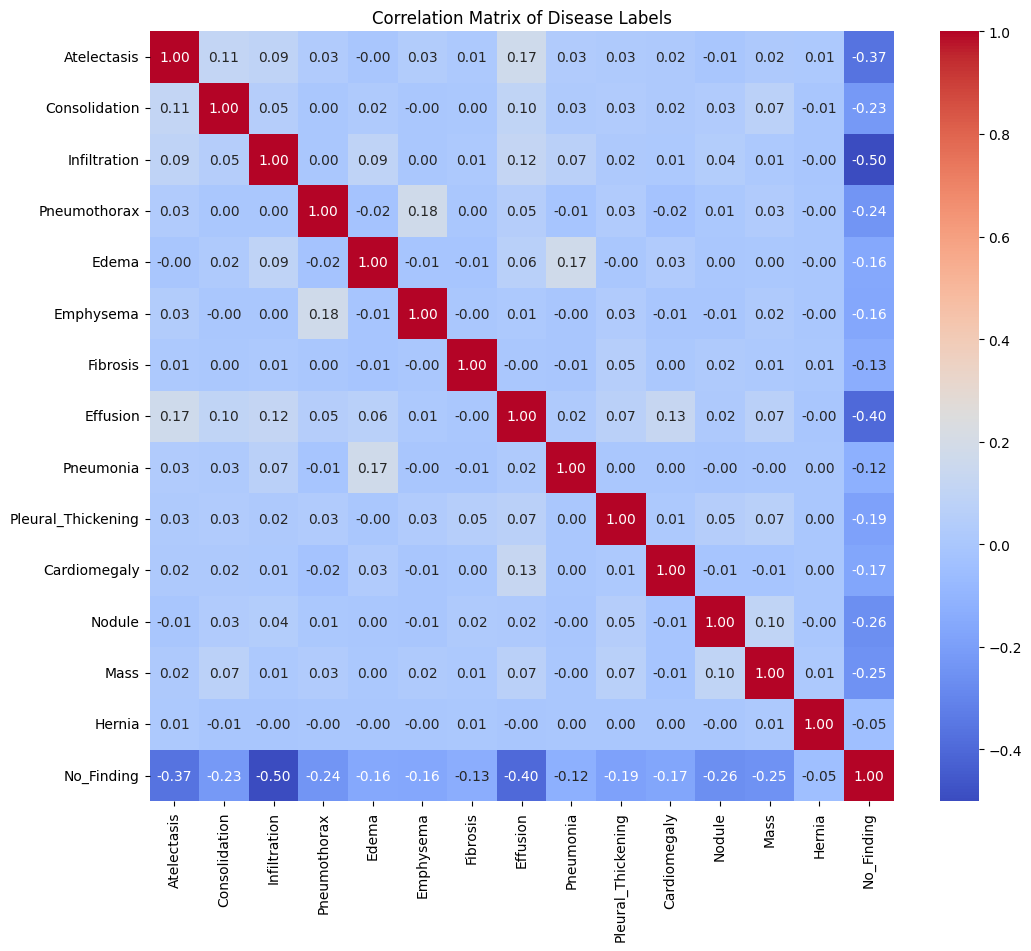

In [11]:
plt.figure(figsize=(12, 10))
sns.heatmap(labels_df[disease_labels + ['No_Finding']].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix of Disease Labels")
plt.show()

# **Step 5: Split Dataset**

In [12]:
# Get Unique Patient IDs
unique_patients = labels_df['Patient ID'].unique()

# Split Patients into Train+Val and Test (80-20)
train_val_patients, test_patients = train_test_split(
    unique_patients,
    test_size=0.2,
    random_state=SEED,
    shuffle=True
)

# Create DataFrames
train_val_df = labels_df[labels_df['Patient ID'].isin(train_val_patients)].reset_index(drop=True)
test_df = labels_df[labels_df['Patient ID'].isin(test_patients)].reset_index(drop=True)

# Verify Split Sizes
print(f"Train size: {train_val_df.shape[0]}")
print(f"Test size: {test_df.shape[0]}")

Train size: 89826
Test size: 22294


# **Step 5: Self-Supervised Pre-Training with SimCLR**

In [13]:
# Import FastAI Libraries
import fastai
from fastai.vision.all import *

In [23]:
import torchvision.transforms as T

transform = T.Compose([
    T.RandomResizedCrop(size=224),
    T.RandomHorizontalFlip(),
    T.RandomApply([T.ColorJitter(0.8, 0.8, 0.8, 0.2)], p=0.8),
    T.RandomGrayscale(p=0.2),
    T.GaussianBlur(kernel_size=9, sigma=(0.1, 2.0)),
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

**Define the SimCLR Model Architecture**

**Create a DataBlock and DataLoaders for SimCLR**

**Initialize the Encoder with ImageNet-1K Pretrained Weights**

**Initialize the SimCLR Model**

In [19]:
def nt_xent_loss(z_i, z_j, temperature=0.5):
    batch_size = z_i.shape[0]
    z = torch.cat([z_i, z_j], dim=0)
    similarity_matrix = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2)

    mask = torch.eye(2 * batch_size, dtype=torch.bool).to(z.device)
    similarity_matrix = similarity_matrix[~mask].view(2 * batch_size, -1)

    pos_sim = torch.exp(F.cosine_similarity(z_i, z_j) / temperature)
    neg_sim = torch.sum(torch.exp(similarity_matrix / temperature), dim=1)

    loss = -torch.log(pos_sim / neg_sim).mean()
    return loss

**Train the SimCLR Model**

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SimCLRModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10):  # Adjust as needed
    model.train()
    epoch_loss = 0
    for xi, xj in dataloader:
        xi, xj = xi.to(device), xj.to(device)
        z_i, z_j = model(xi), model(xj)
        loss = nt_xent_loss(z_i, z_j)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/10], Loss: {epoch_loss / len(dataloader):.4f}")

/tmp/ipykernel_1836658/2130604707.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/10:   0%|          | 0/2807 [00:00<?, ?it/s]/tmp/ipykernel_1836658/2130604707.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/10:   0%|          | 0/2807 [00:12<?, ?it/s]


RuntimeError: shape '[64, 1]' is invalid for input of size 62

# **Step 6: Data Processing Part 2**

**Prepare DataLoader for Training**

In [ ]:
# Define datablock
dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock(encoded=True,vocab=disease_labels)),
    splitter=RandomSplitter(valid_pct=0.125, seed=SEED),
    get_x=lambda row: row['Path'],
    get_y=lambda row: row[disease_labels].tolist(),
    item_tfms=[
        Resize((224, 224)),
    ],
    batch_tfms=[
        Flip(),
        Rotate(),
        Normalize.from_stats(*imagenet_stats),
    ]
)

# Create dataloader
dls = dblock.dataloaders(train_val_df, bs=128)

# **Step 7: Build the Model**

In [ ]:
# Define callbacks
cbs = [
    SaveModelCallback(monitor='valid_loss', min_delta=0.0001, with_opt=True),
    EarlyStoppingCallback(monitor='valid_loss', min_delta=0.001, patience=5),
    ShowGraphCallback()
]

# Create the Fastai Learner with the custom model
learn = vision_learner(
    dls,
    swin_v2_t,
    pretrained=True,
    metrics=[accuracy_multi, F1ScoreMulti(), RocAucMulti()],
    cbs=cbs,
    wd=0.001
)

# Wrap the model with DataParallel for multi-GPU training
learn.model = torch.nn.DataParallel(learn.model)

/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Swin_V2_T_Weights.IMAGENET1K_V1`. You can also use `weights=Swin_V2_T_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# **Step 8: Train the Model**

**Find Learning Rate**

/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, ma

intial learning rate= 0.004365158267319202


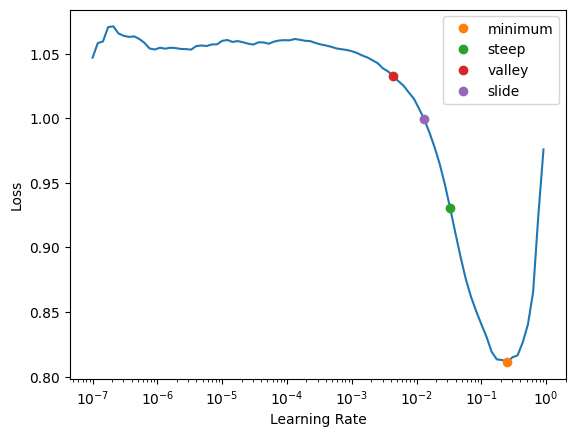

In [ ]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
print('intial learning rate=', lrs.valley)

**Train the Model**

Processing batch 88/614 in epoch 1/11
Finished epoch 1/1
Better model found at epoch 0 with valid_loss value: 0.17275378108024597.


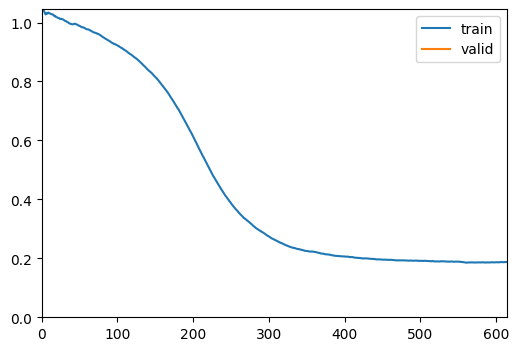

/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, ma

In [ ]:
class PrintBatchProgressCallback(Callback):
    def before_epoch(self):
        print(f"Starting epoch {self.epoch+1}/{self.n_epoch}")

    def before_batch(self):
        total_batches = len(self.dls.train)
        print(f"Processing batch {self.iter+1}/{total_batches} in epoch {self.epoch+1}/{self.n_epoch}", end="\r")

    def after_epoch(self):
        print(f"\nFinished epoch {self.epoch+1}/{self.n_epoch}")

# Use the callback while fine-tuning
learn.fine_tune(
    freeze_epochs=1, 
    epochs=0, 
    base_lr=lrs.valley, 
    cbs=[PrintBatchProgressCallback()]
)

# **Step 9: Evaluate the Model**

**Prepare DataLoader for Test Set**

In [ ]:
# Create DataBlock for the test set
test_dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock(encoded=True, vocab=disease_labels)),
    get_x=lambda row: row['Path'],
    get_y=lambda row: row[disease_labels].values.astype(int).tolist(),
    item_tfms=Resize((224, 224)),
    batch_tfms=[
        Normalize.from_stats(*imagenet_stats)
    ]
)

# Create DataLoaders for the test set
test_dls = test_dblock.dataloaders(test_df, bs=1, shuffle=False)

**Calculate Accuracy and ROC AUC**

In [ ]:
# Get predictions and targets
preds, targs = learn.get_preds(dl=test_dls[0], reorder=False)

# Initialize dictionaries to store metrics
accuracy_per_label = {}
roc_auc_per_label = {}

# Compute metrics for each label
for i, label in enumerate(disease_labels):
    acc = accuracy_score(targs[:, i], preds_binary[:, i])
    roc_auc = roc_auc_score(targs[:, i], preds[:, i])
    accuracy_per_label[label] = acc
    roc_auc_per_label[label] = roc_auc

# Display metrics per label
metrics_df = pd.DataFrame({
    'Accuracy': accuracy_per_label,
    'ROC AUC': roc_auc_per_label
}).T

metrics_df

,Atelectasis,Consolidation,Infiltration,Pneumothorax,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia
Accuracy,0.900482,0.958174,0.814084,0.953689,0.979255,0.975723,0.983741,0.885400,0.987049,0.970509,0.971406,0.941915,0.950101,0.997869
ROC AUC,0.694602,0.741437,0.642055,0.787133,0.835061,0.812983,0.716149,0.767094,0.668723,0.671613,0.654632,0.621743,0.642256,0.718729


**Plot ROC curves for each label**

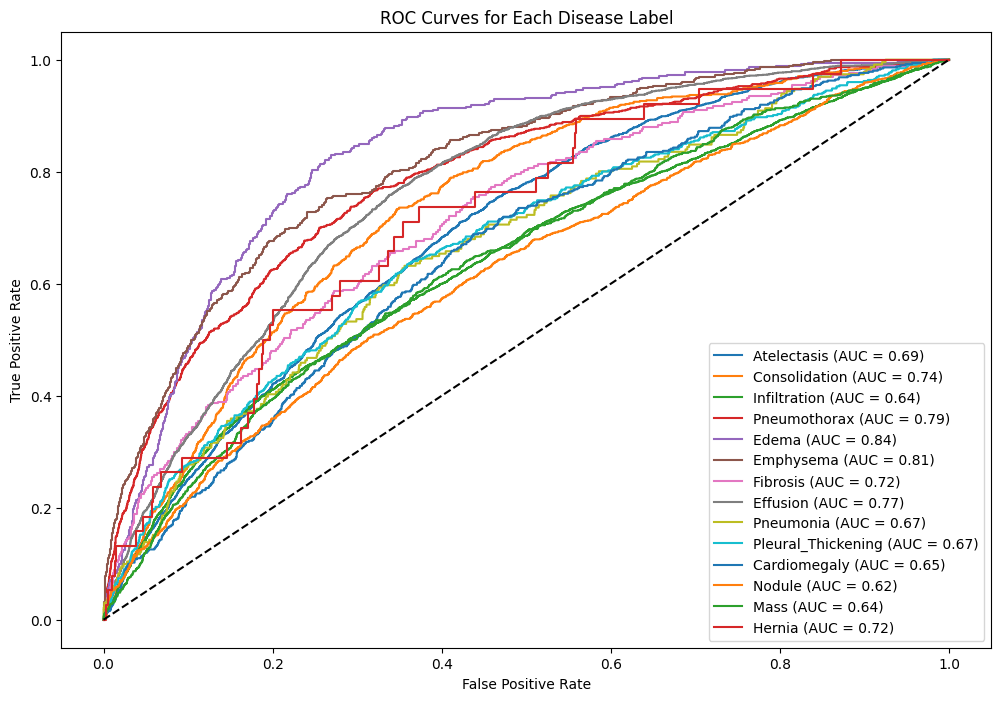

In [ ]:
plt.figure(figsize=(12, 8))
for i, label in enumerate(disease_labels):
    fpr, tpr, _ = roc_curve(targs[:, i].cpu(), preds[:, i].cpu())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Disease Label')
plt.legend(loc='lower right')
plt.show()